<ipython-input-3-7741ee516b63>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')
<ipython-input-3-7741ee516b63>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')
<ipython-input-3-7741ee516b63>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')
<ipython-input-3-7741ee516b63>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor release

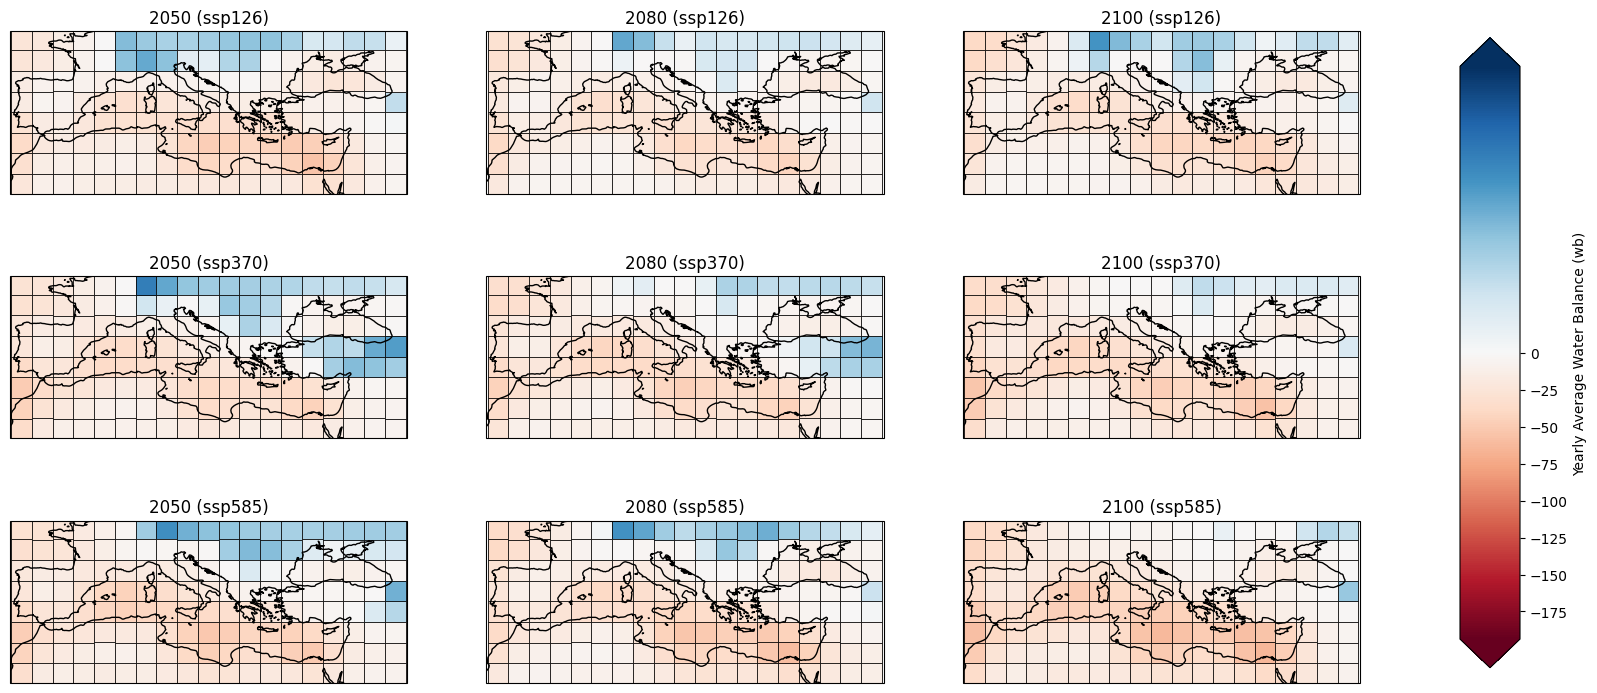

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
import numpy as np

# Define the base directory and scenarios
base_dir = 'Predictor'
scenarios = ['ssp126', 'ssp370', 'ssp585']
years = [2050, 2080, 2100]

# Collect all water balance values to determine global min and max based on percentiles
all_wb_values = []

for scenario in scenarios:
    scenario_folders = [f for f in os.listdir(base_dir) if scenario in f]
    for folder in scenario_folders:
        folder_path = os.path.join(base_dir, folder)
        csv_file = f'{scenario}_spei.csv'
        csv_path = os.path.join(folder_path, csv_file)
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            all_wb_values.extend(df['wb'].tolist())  # Collect 'wb' values

# Use percentiles to dynamically adjust vmin and vmax for the color scale
vmin = np.percentile(all_wb_values, 10)  # 10th percentile
vmax = np.percentile(all_wb_values, 90)  # 90th percentile
vcenter = 0  # Center the colormap at 0

# Ensure vmin < vcenter < vmax by adjusting if necessary
if vmin > vcenter:
    vmin = min(all_wb_values)
if vmax < vcenter:
    vmax = max(all_wb_values)

# Function to plot map for a given year and scenario with yearly average water balance data
def plot_map_for_year_scenario(ax, data, year, scenario, vmin, vcenter, vmax):
    ax.coastlines()
    ax.set_extent([-10, 43.8, 28, 50], crs=ccrs.PlateCarree())  # Focus on the Mediterranean region
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    cmap = cm.get_cmap('RdBu')

    for index, row in data.iterrows():
        lon_center = row['Longitude']
        lat_center = row['Latitude']
        wb = row['wb']  # Use 'wb' column for water balance
        delta_lon = 2.8125 / 2
        delta_lat = 2.8125 / 2
        lower_left = [lon_center - delta_lon, lat_center - delta_lat]

        rect = mpatches.Rectangle(lower_left, 2.8125, 2.8125, transform=ccrs.PlateCarree(),
                                  facecolor=cmap(norm(wb)), linewidth=0.5, edgecolor='black')
        ax.add_patch(rect)

    ax.set_title(f'{year} ({scenario})')

# Create a figure with subplots arranged in a grid
fig, axs = plt.subplots(len(scenarios), len(years), figsize=(20, 9), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(right=0.8)

for i, scenario in enumerate(scenarios):
    for j, year in enumerate(years):
        all_data = []
        # Loop through each folder within the scenario
        scenario_folders = [f for f in os.listdir(base_dir) if scenario in f]
        for folder in scenario_folders:
            folder_path = os.path.join(base_dir, folder)
            csv_file = f'{scenario}_spei.csv'
            csv_path = os.path.join(folder_path, csv_file)
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                # Filter the DataFrame for the specified year
                year_data = df[df['year'] == year]
                if not year_data.empty:
                    all_data.append(year_data[['Longitude', 'Latitude', 'wb']])

        # Combine data from all folders
        combined_data = pd.concat(all_data, ignore_index=True)

        # Plot the map for the current scenario and year with water balance data
        ax = axs[i, j] if len(scenarios) > 1 else axs[j]
        if not combined_data.empty:
            plot_map_for_year_scenario(ax, combined_data, year, scenario, vmin, vcenter, vmax)

# Add a global colorbar for water balance
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])  # Adjust the position and size as needed
sm = cm.ScalarMappable(cmap='RdBu', norm=TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cbar_ax, label='Yearly Average Water Balance (wb)', extend='both')

plt.show()
